# setup

In [1]:
import h5py
import numpy as np
import os
import pandas as pd
import sys

from util.trial_analysis import get_trial_len
from util.trial_analysis import plot_cell_tuning_curve
from util.trial_analysis import plot_repeat_response

from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis 

from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# %matplotlib notebook
# %matplotlib qt

from __future__ import print_function

drive_path = '/data/dynamic-brain-workshop/visual_behavior'
manifest_file = 'visual_behavior_data_manifest.csv'
manifest = pd.read_csv(os.path.join(drive_path,manifest_file))

In [174]:
# find experiment ids
targeted_structure = 'VISal'
# cre_line = 'Slc17a7-IRES2-Cre'
cre_line = 'Vip-IRES-Cre'
session_type = 'behavior_session_A'
manifest[(manifest['targeted_structure']==targeted_structure) & (manifest['cre_line']==cre_line) & (manifest['session_type']==session_type)]

,experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,specimen_id,experiment_date
8,648647430,648562391,VISal,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_A,330982,596393048,11/15/2017 11:58
32,700914412,700821114,VISal,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_A,363887,652073919,5/22/2018 15:12
44,715161256,715027436,VISal,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_A,373723,660049533,6/27/2018 11:35


V1, VIP: experiment_id=695471168, cells are tuned to gray

In [189]:
experiment_id = 700914412
experiment_container_id = manifest[manifest.experiment_id==experiment_id].experiment_container_id.values[0]

dataset= VisualBehaviorOphysDataset(experiment_id, cache_dir=drive_path)
dataset.metadata

,ophys_experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,experiment_date,specimen_id,ophys_frame_rate,stimulus_frame_rate
700914412,700914412,None,VISal,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_A,363887,2018-05-22,652073919,31.0,60.0


# trial stimulus parameters

In [190]:
trial_len = get_trial_len(dataset)

In [191]:
# import analysis object
analysis = ResponseAnalysis(dataset)

loading trial response dataframe
loading flash response dataframe


In [192]:
# get image names
stim_table = dataset.get_stimulus_table()
im_name = stim_table['image_name'].unique()
num_im = len(im_name)

# get timestamps
stim_ts = dataset.get_timestamps_stimulus()
ophys_ts = dataset.get_timestamps_ophys()

In [193]:
# dff traces
_, dff = dataset.get_dff_traces()
num_cell = dff.shape[0]

get average response matrix

In [194]:
# select long trials
repeat_start = 0 # start from which repeat in the trial (start with 0)
len_cutoff = 10 # length of trials

# stimlus duration in frames
stim_duration_frame = int(np.ceil(analysis.stimulus_duration*analysis.ophys_frame_rate))

# get response matrix for each flash in each trial
# repeat_resp = np.zeros([num_cell, num_im, len_cutoff, stim_duration_frame*2]) # full response matrix before averaging
avg_resp = np.zeros([num_cell, num_im, len_cutoff]) # num_neuron by num_im by len_cutoff

for im in range(num_im): # loop over image templates

    for trial_block_id in np.where(trial_len['image']==im_name[im])[0]: # loop over trials for the image template

        if trial_len['trial_length'][trial_block_id] < len_cutoff + repeat_start: # skip short trials
            continue
        
        for repeat_ind, j in enumerate(np.arange(trial_len['trial_start'][trial_block_id]+repeat_start, trial_len['trial_start'][trial_block_id]+len_cutoff+repeat_start, 1)): # loop over flashes in each trial
            flash_start = stim_table['start_time'][j]
            #flash_end = stim_table['end_time'][j]
            #ophys_frames = np.where((ophys_ts >= flash_start) & (ophys_ts <= flash_end))[0]
            # baseline_frames = ophys_frames - len(ophys_frames)
            stim_start = np.argmax(ophys_ts >= flash_start)
            stim_frames = np.arange(stim_start, stim_start+stim_duration_frame)
            baseline_frames = np.arange(stim_start-stim_duration_frame, stim_start)

            for neuron in range(num_cell):
#                 repeat_resp[neuron, im, repeat_ind, :] = dff[neuron, np.concatenate((baseline_frames, stim_frames))]
                avg_resp[neuron, im, repeat_ind] = dff[neuron, stim_frames].mean() - dff[neuron, baseline_frames].mean()

plot average response matrix

In [220]:
np.ceil(float(num_cell)/float(num_cell_per_row))

2.0

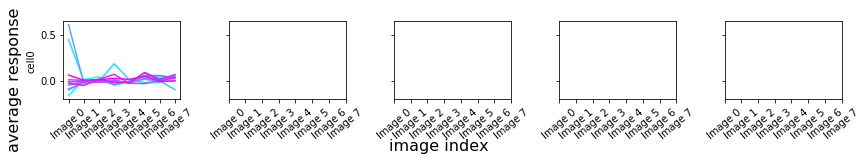

In [214]:
# plot_cell_tuning_curve(avg_resp)

# set colors
color_idx = np.linspace(0, 1, len_cutoff)

# loop over cells
num_cell_per_row = 5
cmap = cm.cool
num_row = int(np.ceil(float(num_cell)/float(num_cell_per_row)))

# create plot
fig, axes = plt.subplots(num_row, num_cell_per_row, sharey=True, figsize=(12, num_row*2))
if num_row==1:
    axes = np.reshape(axes, (num_cell_per_row,-1))

for row in range(num_row):

    cell_start = row*num_cell_per_row
    cell_end = np.max([row*num_cell_per_row+1, num_cell])
    for cell, ax in zip(np.arange(cell_start, cell_end), axes[row,:]): # loop over cells

        for i, c in zip(range(len_cutoff),color_idx): # loop over repeats
            ax.plot(avg_resp[cell,:,i], color=cmap(c))
            ax.set_ylabel('cell' + str(cell))

fig.text(0.5, 0, 'image index', ha='center', fontsize=16)
fig.text(0, 0.5, 'average response', va='center', fontsize=16, rotation='vertical')
plt.setp(axes, xticks=range(8), xticklabels=['Image 0', 'Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 5', 'Image 6', 'Image 7'])
for ax in axes.ravel():
    plt.setp(ax.get_xticklabels(), rotation=40)
plt.tight_layout()
plt.show()

fig.savefig('fig/tuning_curve_flash_' + targeted_structure + '_' + cre_line + '_' + str(experiment_id) + '.pdf')

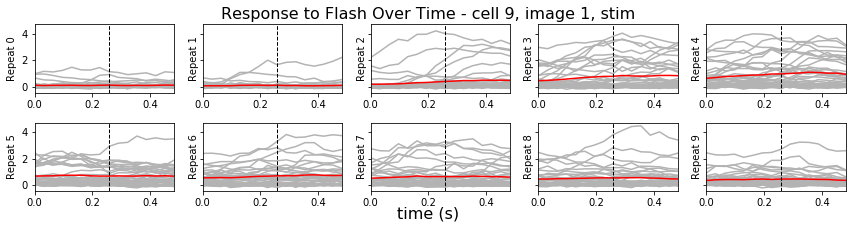

In [186]:
cell = 9 # cell index, start from 0
im = 1 # which image to plot
# repeat = 1 # which repeat to plot, start from 0

# get trial data
im_trials = np.where((trial_len['image']==im_name[im]) & (trial_len['trial_length']>=len_cutoff))[0]
trial_rsp_mat = np.zeros([len(im_trials), len_cutoff, int(stim_duration_frame)*2])

for i, trial_block_id in enumerate(im_trials): # loop over trials for the image template

    for j, repeat_ind in enumerate(np.arange(trial_len['trial_start'][trial_block_id]+repeat_start, trial_len['trial_start'][trial_block_id]+len_cutoff+repeat_start, 1)): # loop over flashes in each trial

        # define frames for current trial block, current repeat
        flash_start = stim_table['start_time'][repeat_ind]
        stim_start = np.argmax(ophys_ts >= flash_start)
        frames = np.arange(stim_start-stim_duration_frame, stim_start+stim_duration_frame)

        # store result
        trial_rsp_mat[i, j, :] = dff[cell, frames]
        
######################################################################
# plot repeate response for selected cell and repeat number

# timestamps for repeats
repeat_ts = np.arange(0, stim_duration_frame*2) / analysis.ophys_frame_rate

fig, axes = plt.subplots(2, 5, sharey=True, figsize=[12,3]) # assume len_cutoff = 10 for now

for repeat ,ax in zip(range(len_cutoff), axes.reshape(-1)):
    
    # plot individual repeats
    for i in range(trial_rsp_mat.shape[0]):
        ax.plot(repeat_ts, trial_rsp_mat[i, repeat, :], color=(0.7, 0.7, 0.7))
    
    # plot average response
    ax.plot(repeat_ts, trial_rsp_mat[:, repeat, :].mean(axis=0), color='r', linewidth=1.5)

    # plot stim time
    ax.axvline(x=repeat_ts[int(stim_duration_frame)], color='k', linewidth=1, linestyle='--')
    ax.set_xlim([repeat_ts[0], repeat_ts[-1]])
    ax.set_ylabel('Repeat ' + str(repeat))

plt.tight_layout()
plt.suptitle('Response to Flash Over Time - cell ' + str(cell) + ', image ' + str(im) + ', stim', fontsize=16)
fig.text(0.5, 0, 'time (s)', ha='center', fontsize=16)
# fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
plt.subplots_adjust(top=0.9)
plt.show()

fig.savefig('fig/cell_response/cell_response_flash_' + targeted_structure + '_' + cre_line + '_' + str(experiment_id) + '_cell_' + str(cell) + '_image_' + str(im) + '.pdf')

In [15]:
im_name[4]

'im065'

# inter-stimulus gray period response

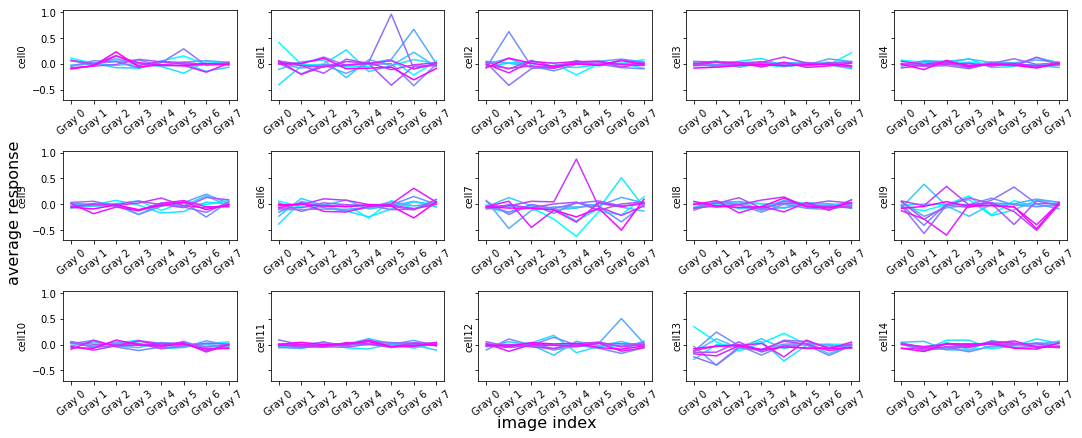

In [187]:
# select long trials
repeat_start = 0 # start from which repeat in the trial (start with 0)
len_cutoff = 10 # length of trials

# stimlus duration in frames
gray_duration_frame = int(np.ceil(analysis.stimulus_duration*analysis.ophys_frame_rate)*2)

# get response matrix for each flash in each trial
avg_resp_gray = np.zeros([num_cell, num_im, len_cutoff]) # num_neuron by num_im by len_cutoff

for im in range(num_im): # loop over image templates

    im_trials = np.where((trial_len['image']==im_name[im]) & (trial_len['trial_length']>=len_cutoff))[0]
    for trial_block_id in im_trials: # loop over trials for the image template

        for repeat_ind, j in enumerate(np.arange(trial_len['trial_start'][trial_block_id]+repeat_start, trial_len['trial_start'][trial_block_id]+len_cutoff+repeat_start, 1)): # loop over flashes in each trial
            flash_start = stim_table['start_time'][j]
            gray_end = np.argmax(ophys_ts >= flash_start)
            gray_frames_baseline = np.arange(gray_end-gray_duration_frame, gray_end-gray_duration_frame/2)
            gray_frames_later = np.arange(gray_end-gray_duration_frame/2, gray_end)

            for neuron in range(num_cell):
                avg_resp_gray[neuron, im, repeat_ind] = dff[neuron, gray_frames_later].mean() - dff[neuron, gray_frames_baseline].mean()


#################################################################
# plot tuning curve
# plot_cell_tuning_curve(avg_resp_gray)

# set colors
color_idx = np.linspace(0, 1, len_cutoff)

# loop over cells
num_cell_per_row = 5
cmap = cm.cool
num_row = int(np.ceil(float(num_cell)/float(num_cell_per_row)))

# create plot
fig, axes = plt.subplots(num_row, num_cell_per_row, sharey=True, figsize=(15,num_row*2))

for row in range(num_row):

    cell_start = row*num_cell_per_row
    cell_end = np.max([row*num_cell_per_row+1, num_cell])
    for cell, ax in zip(np.arange(cell_start, cell_end), axes[row,:]): # loop over cells

        for i, c in zip(range(len_cutoff),color_idx): # loop over repeats
            ax.plot(avg_resp_gray[cell,:,i], color=cmap(c))
            ax.set_ylabel('cell' + str(cell))
            
        #ax.set_xticks(range(8), ['Gray 0', 'Gray 1', 'Gray 2', 'Gray 3', 'Gray 4', 'Gray 5', 'Gray 6', 'Gray 7'])#, rotation=40)

fig.text(0.5, 0, 'image index', ha='center', fontsize=16)
fig.text(0, 0.5, 'average response', va='center', fontsize=16, rotation='vertical')
plt.setp(axes, xticks=range(8), xticklabels=['Gray 0', 'Gray 1', 'Gray 2', 'Gray 3', 'Gray 4', 'Gray 5', 'Gray 6', 'Gray 7'])
for ax in axes.ravel():
    plt.setp(ax.get_xticklabels(), rotation=40)
plt.tight_layout()
plt.show()

fig.savefig('fig/tuning_curve_gray_' + targeted_structure + '_' + cre_line + '_' + str(experiment_id) + '.pdf')

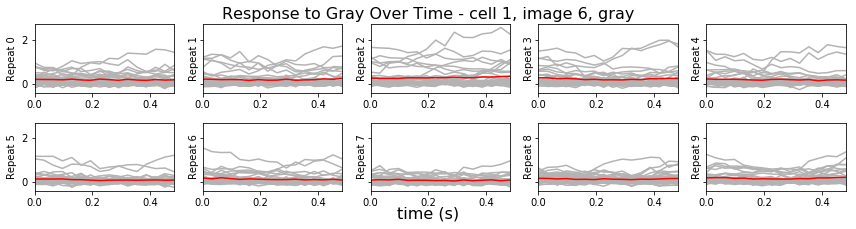

In [188]:
cell = 1 # cell index, start from 0
im = 6 # which image to plot

# get trial data
im_trials = np.where((trial_len['image']==im_name[im]) & (trial_len['trial_length']>=len_cutoff))[0]
gray_rsp_mat = np.zeros([len(im_trials), len_cutoff, int(stim_duration_frame)*2])

for i, trial_block_id in enumerate(im_trials): # loop over trials for the image template

    for j, repeat_ind in enumerate(np.arange(trial_len['trial_start'][trial_block_id]+repeat_start, trial_len['trial_start'][trial_block_id]+len_cutoff+repeat_start, 1)): # loop over flashes in each trial

        # define frames for current trial block, current repeat
        flash_start = stim_table['start_time'][repeat_ind]
        stim_start = np.argmax(ophys_ts >= flash_start)
        gray_frames = np.arange(stim_start-2*stim_duration_frame, stim_start)

        # store result
        gray_rsp_mat[i, j, :] = dff[cell, gray_frames]
        
######################################################################
# plot repeate response for selected cell and repeat number

# timestamps for repeats
gray_ts = np.arange(0, stim_duration_frame*2) / analysis.ophys_frame_rate

fig, axes = plt.subplots(2, 5, sharey=True, figsize=[12,3]) # assume len_cutoff = 10 for now

for repeat ,ax in zip(range(len_cutoff), axes.reshape(-1)):
    
    # plot individual repeats
    for i in range(gray_rsp_mat.shape[0]):
        ax.plot(gray_ts, gray_rsp_mat[i, repeat, :], color=(0.7, 0.7, 0.7))
    
    # plot average response
    ax.plot(gray_ts, gray_rsp_mat[:, repeat, :].mean(axis=0), color='r', linewidth=1.5)

    # plot stim time
    # ax.axvline(x=repeat_ts[int(stim_duration_frame)], color='k', linewidth=1, linestyle='--')
    ax.set_xlim([gray_ts[0], gray_ts[-1]])
    ax.set_ylabel('Repeat ' + str(repeat))

plt.tight_layout()
plt.suptitle('Response to Gray Over Time - cell ' + str(cell) + ', image ' + str(im) + ', gray', fontsize=16)
fig.text(0.5, 0, 'time (s)', ha='center', fontsize=16)
# fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
plt.subplots_adjust(top=0.9)
plt.show()

fig.savefig('fig/cell_response/cell_response_gray_' + targeted_structure + '_' + cre_line + '_' + str(experiment_id) + '_cell_' + str(cell) + '_gray_' + str(im) + '.pdf')

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')


# x = np.arange(1,9,1)
# y = np.arange(0,10,1)
# X, Y = np.meshgrid(x, y)

# # num_images by num_repeats
# zs = avg_resp[0,:,:]
# Z = zs.reshape(X.shape)

# ax.plot_surface(X,Y,Z,cmap=cm.coolwarm)
# ax.set_xlabel('Image ID')
# ax.set_ylabel('$t_k$')
# ax.set_zlabel('Response')

# plt.show()